# (8) Inference using the Hellinger Distance (HD).

In this notebook we assess the ability of the SMC-ABC algorithm to infer known parameters from artificial simulated data from the SSA using the probability distribution over the trajectory and the HD as the distance measure. This allows us to assess the ability of the SMC-ABC implemented to predict known parameters, as well as allowing us to assess whether the various objective functions have an impact on the inference.

Let's start by importing the SSA and the experimental data (only to be used to given initial volumes, molecule numbers and exponential growth rates) and processing it as was done in notebook 5:

In [1]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;
using DelimitedFiles;

In [2]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [3]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)]; # non-separated fluor data.
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)]; # non-separated vol data.

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage sep into gens.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage sep into gens.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt data for each lineage sep into gens.

fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep molecule number and concs for each lineage (including 70th gen to be removed) later).
num_all_lins = [fluor_all_lins[x]./fpm for x in 1:length(fluor_all_lins)];
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm;
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

## First attempt at inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\log_{10}(\alpha_0) = 0.5$, $\alpha_1 = 1.0$, $\log_{10}(\beta_0) = -1.8$ and $\beta_1 = 0.3$:

In [4]:
true_par = [0.5,0.3,0.0,0.5];

In [5]:
lineage_data = num_sep_all_lins[1]; # take the data for the first lineage, this gives the data form for Single_lin.
lin_ic = v0_n0_th[1]; # pre-set params for lineage 1.

function Single_lin(lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA_deg_zero_log(1, inf_par, ics[i], length(gen)); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, ssa[1]); append!(SSA_data_c, ssa[2]); append!(SSA_data_v, ssa[3]);
    end
    return convert(Array{Float64,2},transpose(SSA_data_n)), convert(Array{Float64,2},transpose(SSA_data_c)), SSA_data_v # return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [6]:
expt_ssa_conc = Single_lin(lineage_data, true_par, v0_n0_th[1])[2]

1×2146 Array{Float64,2}:
 145.52  145.128  148.291  149.877  …  110.202  108.46  107.91  107.769

Let's plot this data:

In [7]:
using GpABC, LambertW, Distances, Plots, Distributions, LaTeXStrings, StatsBase, LinearAlgebra; pyplot()

Plots.PyPlotBackend()

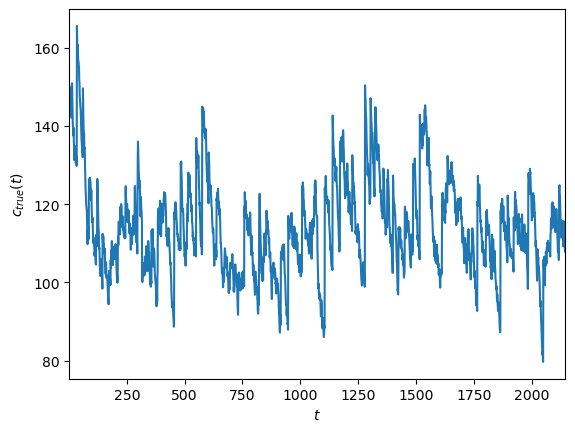

In [8]:
PyPlot.plot(range(1,length(expt_ssa_conc),step=1),expt_ssa_conc[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc)]);

Plot the histogram (appropriately chosen x axis) and store the bin values as from the PDF.


0.99

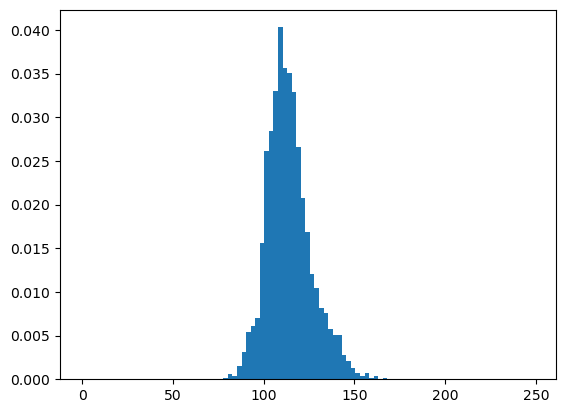

In [9]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0, maximum(expt_ssa_conc)*1.5, 100);
true_bin_vals, other_stuff = ax.hist(expt_ssa_conc[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals*(maximum(expt_ssa_conc)*1.5/100))) # check the sum of bins is 1.

true_bin_vals_form = convert(Array{Float64,2},transpose(true_bin_vals));

Now let's set up the tools needed to perform the inference of the parameters as we did in notebook 5. In this case the output will be the bin values for the histogram of the trajectory. Later we will specify the Hellinger distance measure in the SMC-ABC options.

In [10]:
# function that returns the SSA concentration for lineage specified abvove.
function simulator_function_conc(var_params)
    lin_conc = Single_lin(lineage_data[:], var_params, lin_ic)[2]
    bin_vals = normalize(fit(Histogram, lin_conc[:], mod_bins), mode=:probability).weights;
    return convert(Array{Float64,2},transpose(bin_vals))
end

simulator_function_conc (generic function with 1 method)

In [11]:
thres_cutoff = sum(hellinger(simulator_function_conc(true_par)[:], true_bin_vals_form[:]) for i in 1:1000)/1000

0.09251638387255698

Start the inference:
- (1) `n_particles` gives the number of accepted ABC parameter sets for each step in the threshold simulator.
- (2) `threshold_schedule` gives the different thresholds for the SMC-ABC inference.
- (3) `reference_data_c` is the concentration data for the first 69 generations in lineage 1.
- (4) `priors` is the array containing the priors on each inferred parameter (chosen to be uniform).

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 93/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 179/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 0.35
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 104/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 67/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 128/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/a

┌ Info: GpABC SMC simulation accepted 123/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 132/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 144/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 150/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 157/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 175/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 187/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 199/18000 particles.
└ @ GpABC /home/s1402978

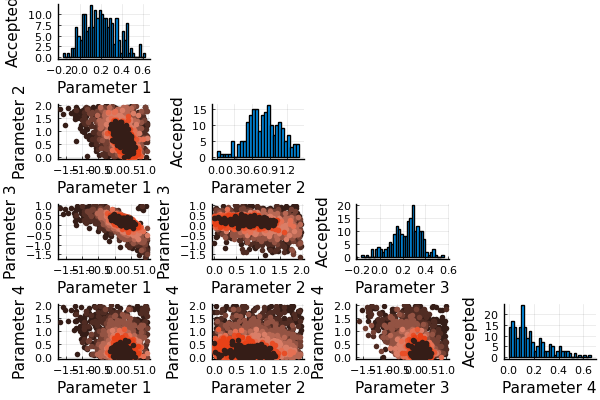

In [79]:
n_particles = 200;
threshold_schedule = [0.5, 0.35, 0.25, 0.2, 0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.09, 0.08];

priors = [Uniform(-3.0, 1.0), Uniform(0.0, 2.0), Uniform(-3.0, 1.0),
          Uniform(0.0, 2.0)];

sim_abcsmc_res_conc_1 = SimulatedABCSMC(true_bin_vals_form,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = Distances.hellinger,
    max_iter = convert(Int,1E5))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67", "#E57053","#E75935","#E84D26","#E84117","#CF3008"]#,"#AB2402"]#,"#351D17"]
plot(sim_abcsmc_res_conc_1, population_colors=population_colors)

Print the median inferred parameters.

In [96]:
pars_conc_1 = [median(sim_abcsmc_res_conc_1.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.19365734085965125
 0.7993045954848417
 0.254781131050414
 0.1289172973564247

In [16]:
#pars_conc_1 = [0.19365734085965125, 0.7993045954848417, 0.254781131050414, 0.1289172973564247];

In [167]:
true_par

4-element Array{Float64,1}:
 0.5
 0.3
 0.0
 0.5

Print the differences.

In [97]:
diff = (pars_conc_1 - true_par)

4-element Array{Float64,1}:
 -0.30634265914034875
  0.4993045954848417
  0.254781131050414
 -0.3710827026435753

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

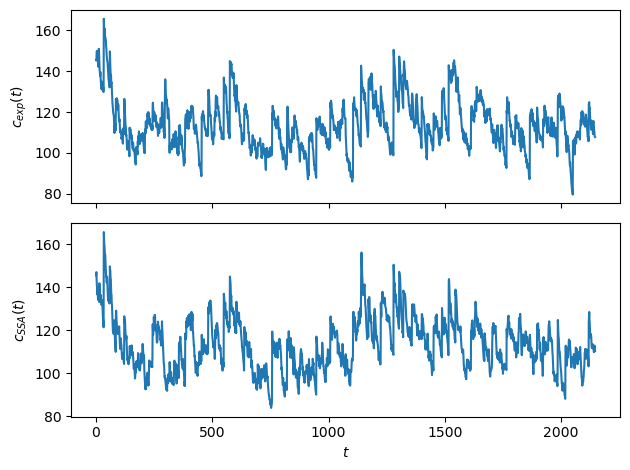

  0.003835 seconds (18.47 k allocations: 1.222 MiB)


In [17]:
single = @time Single_lin(num_sep_all_lins[1], pars_conc_1, v0_n0_th[1]); # do for first gen.
concs_ssa_1 = single[2][1:length(single[2])]; expt_c = expt_ssa_conc[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c),step=1),expt_c); axs[2].plot(range(1,length(concs_ssa_1),step=1),concs_ssa_1);

The inability to infer parameters here seems to arise from the indistinguishability of parameter sets with respect to this objective function of the HD. This is also shown above by the similarity of the behaviour in the concentration trajectories.

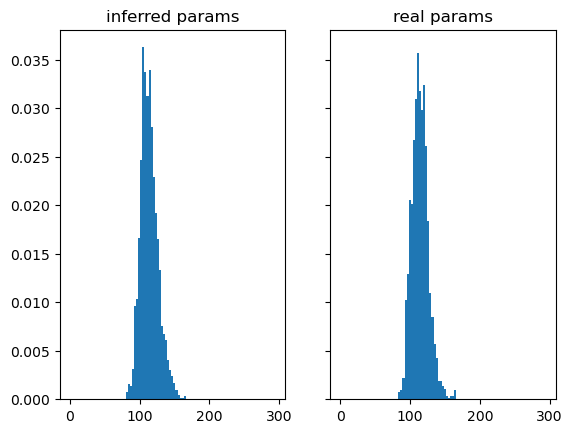

Hellinger distance between these is: 0.0911854843043214
1.6409283859514283

In [99]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_1[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_ssa_conc[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.
print("\n",sum(true_bin_vals_inf*(maximum(concs_ssa_1)/34))) # check the sum of bins is 1.

## Second inference from artificial data

Now let's create the experimental data of which we wish to infer the parameters of. We again introduce the lineage function created in notebook 5. We set $\log_{10}(\alpha_0) = 0.5$, $\alpha_1 = 1.0$, $\log_{10}(\beta_0) = -1.8$ and $\beta_1 = 0$:

In [53]:
true_par_2 = [0.0,0.0001,0.5,1.0];

Question: can we infer $\beta_1 = 0$ without performing inference of $\beta_1$ in log scale? We take the initial conditions on molecule numbers and volume from lineage 1 of the Tanouchi data, as well as the fluorescence per molecule and exponenital growth rate in each generation.

In [54]:
expt_ssa_conc_2 = Single_lin(num_sep_all_lins[1], true_par_2, v0_n0_th[1])[2];

Let's plot this data:

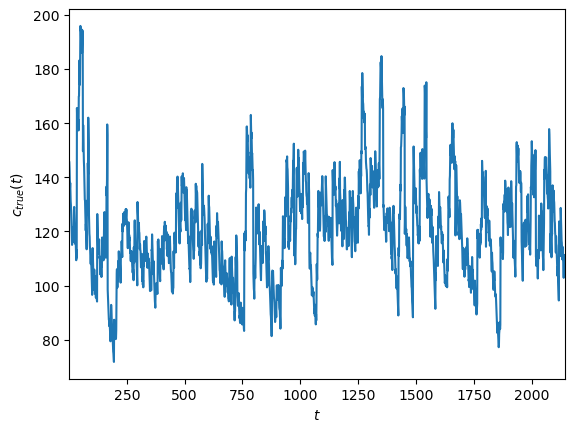

In [55]:
PyPlot.plot(range(1,length(expt_ssa_conc_2),step=1),expt_ssa_conc_2[:]);
PyPlot.ylabel(L"c_{true}(t)"); PyPlot.xlabel(L"t"); PyPlot.xlim([1,length(expt_ssa_conc_2)]);

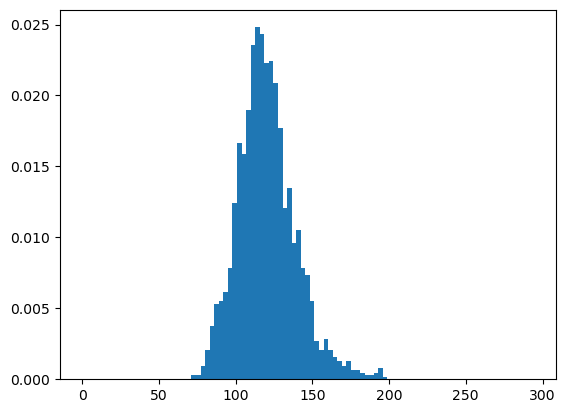


1.9411764705882353

In [85]:
fig, ax = PyPlot.subplots(1,1);
mod_bins = LinRange(0, maximum(expt_ssa_conc_2)*1.5, 100);
true_bin_vals_2, other_stuff = ax.hist(expt_ssa_conc_2[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals_2*(maximum(expt_ssa_conc_2)/34))) # check the sum of bins is 1.

true_bin_vals_form_2 = convert(Array{Float64,2},transpose(true_bin_vals_2));

In [100]:
thres_cutoff = sum(hellinger(simulator_function_conc(true_par_2)[:], true_bin_vals_form_2[:]) for i in 1:1000)/1000

0.11486604663349366

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 92/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 65/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 134/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 194/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.2
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 60/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238


┌ Info: GpABC SMC simulation accepted 102/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 107/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 115/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 120/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 125/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 135/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 146/19000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 153/20000 particles.
└ @ GpABC /home/s1402978

┌ Info: GpABC SMC simulation accepted 6/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 6/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 7/7000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 7/8000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 9/9000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 11/10000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 11/11000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 11/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/G

┌ Info: GpABC SMC simulation accepted 74/69000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/70000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/71000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/72000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/73000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 74/74000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 77/75000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 78/76000 particles.
└ @ GpABC /home/s1402978/.julia/

┌ Info: GpABC SMC simulation accepted 146/133000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 149/134000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 150/135000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 151/136000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 154/137000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 154/138000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 155/139000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 156/140000 particles.
└ @ GpABC /home/

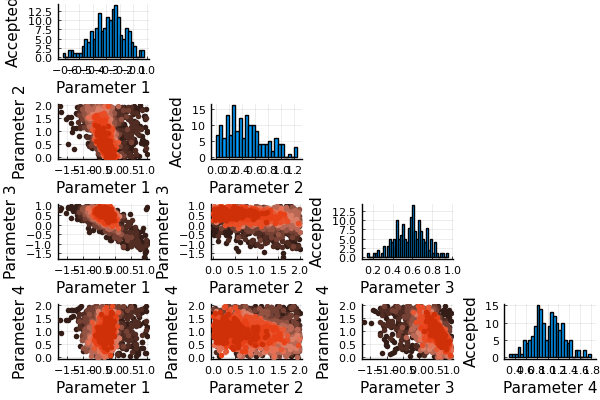

In [101]:
n_particles = 200;
threshold_schedule = [0.5, 0.25, 0.2, 0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.09, 0.08];

priors = [Uniform(-3.0, 1.0), Uniform(0.0, 2.0), Uniform(-3.0, 1.0),
          Uniform(0.0, 2.0)];

sim_abcsmc_res_conc_2 = SimulatedABCSMC(true_bin_vals_form_2,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = Distances.hellinger,
    max_iter = convert(Int,15E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008","#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_2, population_colors=population_colors)

Print the inferred median parameters.

In [102]:
pars_conc_2 = [median(sim_abcsmc_res_conc_2.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 -0.27156263091425636
  0.42928194305057965
  0.594755641587775
  1.0083907392816394

Print the differences.

In [103]:
diff_2 = (pars_conc_2 - true_par_2)

4-element Array{Float64,1}:
 -0.27156263091425636
  0.42918194305057966
  0.09475564158777505
  0.008390739281639359

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

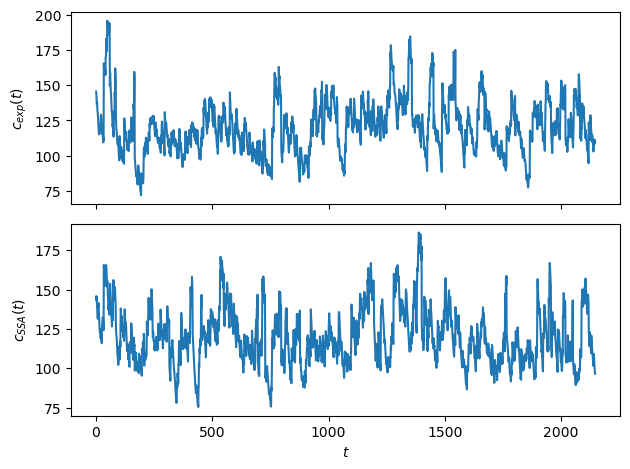

  0.001165 seconds (11.86 k allocations: 632.266 KiB)


In [104]:
single_2 = @time Single_lin(num_sep_all_lins[1], pars_conc_2, v0_n0_th[1]); # do for first gen.
concs_ssa_2 = single_2[2][1:length(single_2[2])]; expt_c_2 = expt_ssa_conc_2[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt_c_2),step=1),expt_c_2); axs[2].plot(range(1,length(concs_ssa_2),step=1),concs_ssa_2);

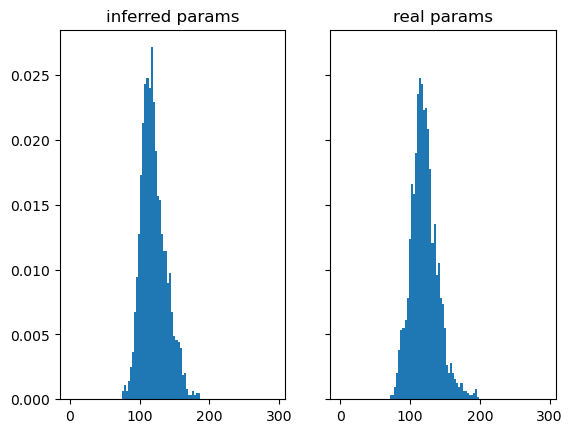

Hellinger distance between these is: 0.10277029461662428

In [112]:
fig, ax = PyPlot.subplots(1, 2, sharey = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_2[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals, other_stuff = ax[2].hist(expt_ssa_conc_2[:], bins = mod_bins, density = true);
ax[2].set_title("real params");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals[:])) # print the bin values.


Again we see the ability to conduct inference is due to the indistinguishability between parameter sets with respect to the HD distance measure.

## Inference on Experimental data

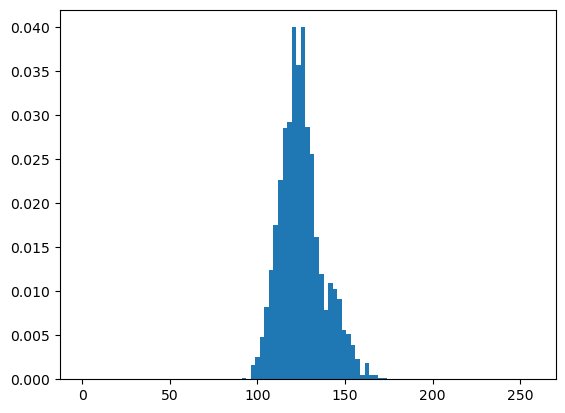


0.9899999999999999

In [18]:
fig, ax = PyPlot.subplots(1,1);
reference_data_exp = conc_all_lins[1][1:length(single[2])]; # first lin.
mod_bins = LinRange(0, maximum(reference_data_exp)*1.5, 100);
true_bin_vals_exp, other_stuff = ax.hist(reference_data_exp[:], bins = mod_bins, density = true);
print("\n",sum(true_bin_vals_exp*(maximum(reference_data_exp)*1.5/100))) # check the sum of bins is 1.

true_bin_vals_exp = convert(Array{Float64,2},transpose(true_bin_vals_exp));

┌ Info: GpABC rejection simulation. ϵ = 0.5.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:47
┌ Info: GpABC rejection simulation. Accepted 52/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 110/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC rejection simulation. Accepted 175/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/rejection.jl:87
┌ Info: GpABC SMC simulation ϵ = 0.25
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 20/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 38/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 54/3000 particles.
└ @ GpABC /home/s1402978/.ju

┌ Info: GpABC SMC simulation accepted 198/39000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 0.14
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:193
┌ Info: GpABC SMC simulation accepted 31/1000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 55/2000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 78/3000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 109/4000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 135/5000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 162/6000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/s

┌ Info: GpABC SMC simulation accepted 62/12000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 68/13000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 76/14000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 86/15000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 90/16000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 96/17000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 101/18000 particles.
└ @ GpABC /home/s1402978/.julia/packages/GpABC/cR3wm/src/abc/smc.jl:238
┌ Info: GpABC SMC simulation accepted 107/19000 particles.
└ @ GpABC /home/s1402978/.juli

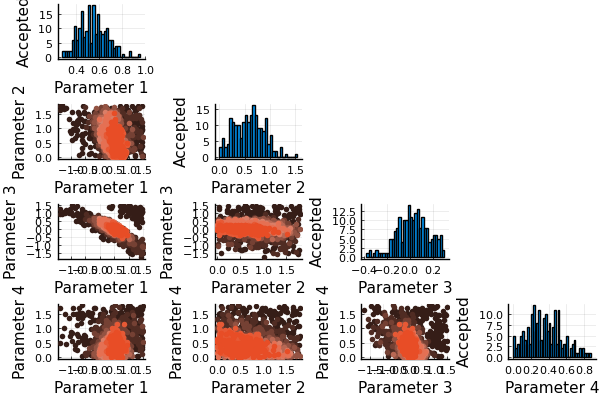

In [22]:
n_particles = 200;
mod_bins = LinRange(0, maximum(reference_data_exp)*1.5, 100);
threshold_schedule = [0.5, 0.25, 0.2, 0.15, 0.14, 0.13, 0.12, 0.11, 0.10];

priors = [Uniform(-4.0, 1.5), Uniform(0.0, 1.8), Uniform(-4.0, 1.5),
          Uniform(0.0, 1.8)];

sim_abcsmc_res_conc_exp = SimulatedABCSMC(true_bin_vals_exp,
    simulator_function_conc,
    priors,
    threshold_schedule,
    n_particles;
    write_progress=true,
    distance_function = Distances.hellinger,
    max_iter = convert(Int,15E4))

# plot the results.
population_colors=["#351D17", "#502C23", "#754134", "#935343", "#B86854","#DA7E67","#E57053","#E75935","#E84D26","#E84117","#CF3008"];#,"#AB2402","#351D17"]
plot(sim_abcsmc_res_conc_exp, population_colors=population_colors)

In [23]:
pars_conc_exp = [median(sim_abcsmc_res_conc_exp.population[end][:,i]) for i in 1:4]

4-element Array{Float64,1}:
 0.5424247687491583
 0.5947511178792252
 0.02781080262823944
 0.35448939363552706

Plot an SSA trajectory using the inferred parameters and compare against the experimental SSA.

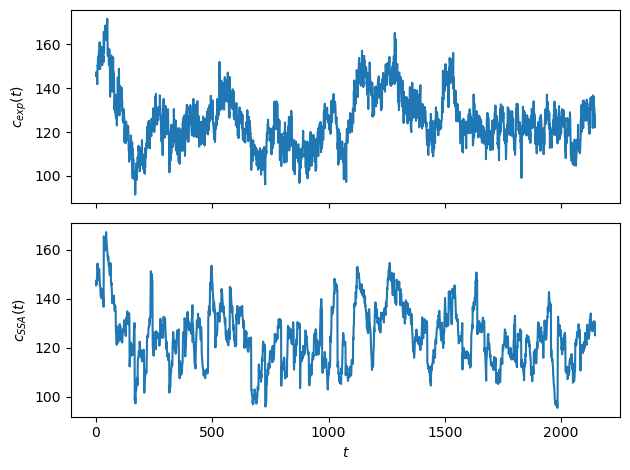

  0.004218 seconds (24.89 k allocations: 1.810 MiB)


In [25]:
single_exp = @time Single_lin(num_sep_all_lins[1], pars_conc_exp, v0_n0_th[1]); # do for first gen.
concs_ssa_exp = single_exp[2][1:length(single_exp[2])]; expt = reference_data_exp[:];

fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(1,length(expt),step=1),expt); axs[2].plot(range(1,length(concs_ssa_exp),step=1),concs_ssa_exp);

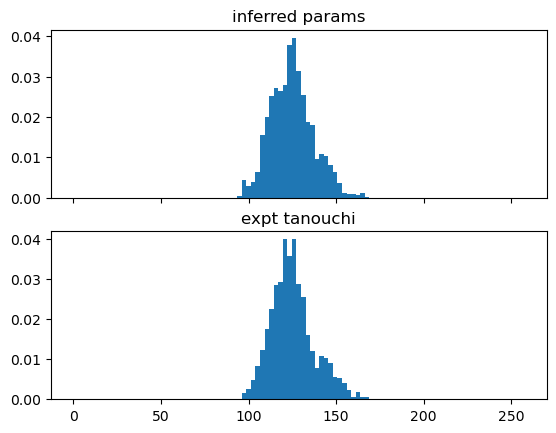

Hellinger distance between these is: 0.08905159564013529

In [31]:
fig, ax = PyPlot.subplots(2, 1, sharex = true);
true_bin_vals_inf, other_stuff = ax[1].hist(concs_ssa_exp[:], bins = mod_bins, density = true);
ax[1].set_title("inferred params"); 
true_bin_vals_exp, other_stuff = ax[2].hist(reference_data_exp[:], bins = mod_bins, density = true);
ax[2].set_title("expt tanouchi");
print("Hellinger distance between these is: ", hellinger(true_bin_vals_inf[:],true_bin_vals_exp[:])) # print the bin values.


## Test of autocorrelation as the objective function

In [106]:
using StatsBase;

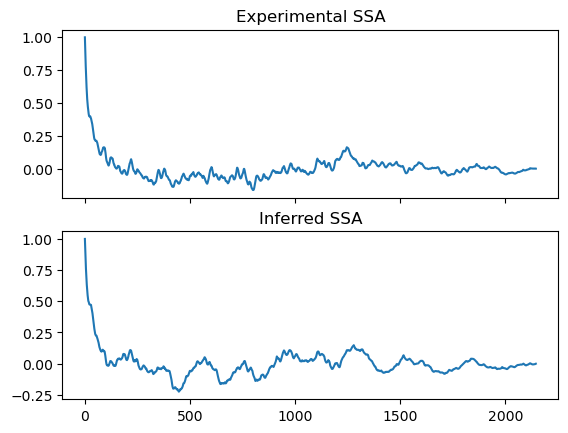

2.4108183953255677

In [147]:
ac_traj_1 = autocor(expt_ssa_conc[:], range(0, length(expt_ssa_conc[:])-1, step=1), demean = true);
ac_traj_1_inf = autocor(concs_ssa_1, range(0, length(expt_ssa_conc[:])-1, step=1), demean = true);
fig, ax = PyPlot.subplots(2,1, sharex = true);
ax[1].plot(ac_traj_1); ax[2].plot(ac_traj_1_inf); ax[1].set_title("Experimental SSA"); ax[2].set_title("Inferred SSA")
ac_dist = euclidean(ac_traj_1,ac_traj_1_inf)

The above shows the comparison between the autocorrelation of the experimental SSA and it's inferred parameters (from the first inference above). Clearly they are very similar - the question to ask is whether their slight differences are enough to identify the true set of parameters. Let's simulate another trajectory with the true set of parameters and see if the autocorrelation distance between them is less than 0.424.

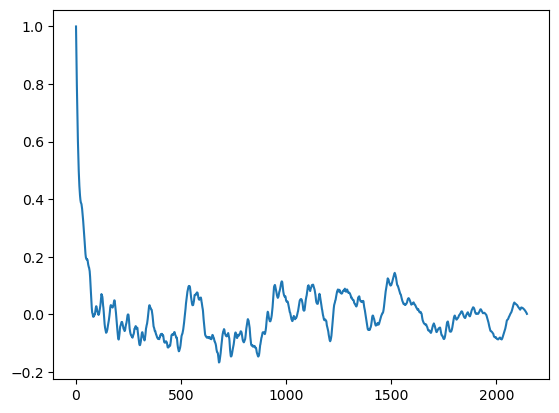

2.514171171465942

In [164]:
expt_ssa_conc_test = Single_lin(lineage_data, true_par, v0_n0_th[1])[2];
ac_traj_1_test = autocor(expt_ssa_conc_test[:], range(0, length(expt_ssa_conc[:])-1, step=1);demean=true);
fig, ax = PyPlot.subplots(1,1, sharex = true); ax.plot(ac_traj_1_test);
dist_test = euclidean(ac_traj_1, ac_traj_1_test)

Result is that the distance is not reliably less than that we wish to infer!!! Hence, the autocorrelation would not provide a good distance function.

In [109]:
using FFTW;

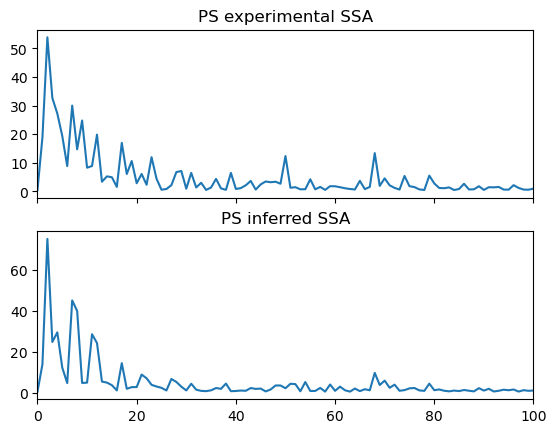

78.76107242974386

In [163]:
ps_1 = fft(ac_traj_1); ps_1_inf = fft(ac_traj_1_inf)
fig, ax = PyPlot.subplots(2,1, sharex = true);
ax[1].plot(ps_1); ax[2].plot(ps_1_inf); ax[1].set_title("PS experimental SSA"); ax[2].set_title("PS inferred SSA")
ax[1].set_xlim([0,100])
ps_dist = euclidean(ps_1[1:100], ps_1_inf[1:100])

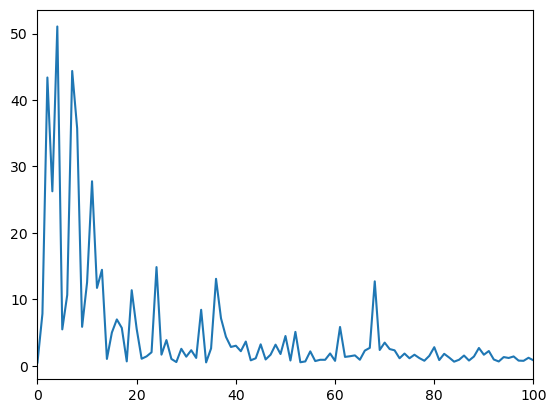

82.18622635118408

In [165]:
ps_1_test = fft(ac_traj_1_test);
fig, ax = PyPlot.subplots(1,1, sharex = true); ax.plot(ps_1_test);
ax.set_xlim([0,100])
ps_dist_2 = euclidean(ps_1[1:100], ps_1_test[1:100])